### Read in Data

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import seaborn as sns
import researchpy as rp
from random import sample 
import geopandas as gpd
from random import sample 
import folium
from folium.plugins import HeatMap
from folium.plugins import FastMarkerCluster
from folium.plugins import MarkerCluster

#from matplotlib.collections import PolyCollection
#from matplotlib.collections import PatchCollection
#from mpl_toolkits.mplot3d import Axes3D
#from descartes.patch import PolygonPatch


In [2]:
listings_detail = pd.read_excel('../CourseProject/data/listings_detail.xlsx', index_col=0)
calendar_detail = pd.read_excel('../CourseProject/data/calendar_detail.xlsx' , index_col=0)
neighbourhoods = pd.read_excel('../CourseProject/data/neighbourhoods.xlsx', index_col=0)
reviews = pd.read_excel('../CourseProject/data/reviews_detail.xlsx', index_col=0)
crime = pd.read_excel('../CourseProject/data/NYPD_Arrests_Data__Historic_.xlsx', index_col=0)
nbgeo = gpd.read_file('../CourseProject/data/neighbourhoods.geojson')
ls=pd.read_csv('../CourseProject/data/listings_summary.csv', index_col=0)

NameError: name 'gpd' is not defined

### Data Cleaning
First see what values are missing and if they are variables that we need.

In [24]:
#How many records we start with
print(f'Number of records: {listings_detail.count()[0]}')

Number of records: 44317


In [4]:
#What is missing in listing summary?
ls.isna().sum()

name                                28
host_id                              0
host_name                          232
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       9440
reviews_per_month                 9474
calculated_host_listings_count       0
availability_365                     0
dtype: int64

No values that are essential to our analysis are missing in listing summary

In [73]:
#What is missing in listing details?
listings_detail.isna().sum()

listing_url                         0    
scrape_id                           0    
last_scraped                        0    
name                                39   
summary                             1523 
space                               14514
description                         29   
experiences_offered                 0    
neighborhood_overview               18720
notes                               28229
transit                             16986
access                              19127
interaction                         19965
house_rules                         19208
thumbnail_url                       3305 
medium_url                          3305 
picture_url                         0    
xl_picture_url                      3305 
host_id                             0    
host_url                            0    
host_name                           232  
host_since                          232  
host_location                       406  
host_about                        

There are many missing values in the listing details dataset which we need to either estimate or eliminate. We estimate the missing reviews per month by using the median values. Then we also want to remove records that do not have a room (bed) and that are "free" or below \\$35, since many that I went through were not really listed as the price in the dataset or are no longer listed so there's no way to check. There were too many below \\$35 to manually go through them all. However, for rooms with a price of \\$2000 or higher (there were only 44), so we manually went through each URL and removed ones that were incorrectly listed in the dataset. There were only a few (10) that are actually listed as that price, and these are penthouses or luxury apartments used for shooting film or photography. It makes sense that there are not many of these, since people who can afford these properties most likely would not bother to rent it out for Airbnb.

<b> Issue: Will we use reviews per month? 

In [28]:
#Fix NaN in review per month 
ls["reviews_per_month"].fillna(0,inplace=True)

#Estimate attempt:
#Use to fill in missing values with median
def impute_median(series):
    return series.fillna(series.median())

listings_detail.loc['reviews_per_month']=listings_detail["reviews_per_month"].transform(impute_median)


#Remove records that do not have a room to offer
listings_detail=listings_detail[listings_detail['beds'] != 0]


#Remove records that are "free" or too low
listings_detail=listings_detail[listings_detail['price']>35]
ls=ls[ls['price']>35]

# Remove records that are incorrectly priced over $2000
listings_detail=listings_detail.drop([20316497,7003697,20649348,16429718,4737930,9528920,12955683,2271504,12520066,16810657,14590978,1448703,18051877,2236419,12376888, 16122505,14800877,20211893,2939700,2281142,18722535,11039478,18889094, 2274084, 19698169, 18109509,18190744,363673, 18323408,13915528,16594414,17975659,15307748])
ls=ls.drop([20316497,7003697,20649348,16429718,4737930,9528920,12955683,2271504,12520066,16810657,14590978,1448703,18051877,2236419,12376888, 16122505,14800877,20211893,2939700,2281142,18722535,11039478,18889094, 2274084, 19698169, 18109509,18190744,363673, 18323408,13915528,16594414,17975659,15307748])

In [29]:
#How many records we have now
print(f'Number of records after cleaning: {listings_detail.count()[0]}')

Number of records after cleaning: 43177


Instead of defining areas by using a center longitude and latitude with a certain radius, we are going to use the pre-defined neighborhoods. Since there are so many (202), we are not going to look at all of them, but will point out ones that are significant (for example, the ones that have the highest ant lowest average prices), and will do research to justify our results.

### Merging

In [9]:
#Merge Calendar Details with Listing Summary 
cdmergels=pd.merge(calendar_detail, ls, left_on='listing_id', right_index=True, how='left')
#Merge all three so we have have the boroughs (neighbourhood_group)
cdmergeldls=pd.merge(cdmergels, listings_detail, left_on='listing_id', right_index=True, how='left')
#Merge Listing Details and Listing Summary
ldmergels=pd.merge(listings_detail,ls,left_index=True, right_index=True, how='left')

### EDA 

In [10]:
#there's 202 unique neighborhoods - do we want to reduce this? how?
listings_detail['neighbourhood'].nunique()

202

In [11]:
print(cdmergels.date.min())
print(cdmergels.date.max())

2017-10-02 00:00:00
2018-10-02 00:00:00


Our Airbnb data is from October 2, 2017 to October 2, 2018

In [12]:
print(crime.ARREST_DATE.min())
print(crime.ARREST_DATE.max())

2014-09-06 00:00:00
2017-12-31 00:00:00


Our crime data is from Septemper 6, 2014 to December 31, 2017

<b> Issue: is this ok that our dates are not over the same range? Not sure if we can find crime data for 2018 but will try

### Question 1: What is the distribution of Airbnbs in NYC?
#### Number of Airbnbs by Borough

In [197]:
#Use host id since there are no missing - meaning we get every record when counting
ls['host_id'].groupby(ls['neighbourhood_group']).count()

neighbourhood_group
Bronx              504
Brooklyn         15386
Manhattan        19320
Queens            3350
Staten Island      222
Name: host_id, dtype: int64

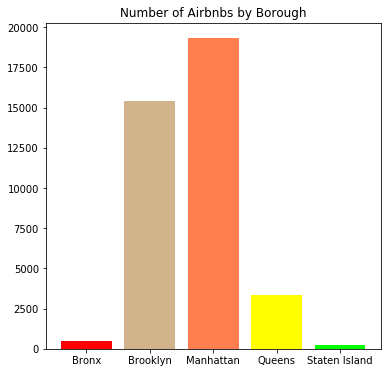

In [205]:
colors=['red','tan','coral','yellow','lime']

plt.figure(figsize = (6,6))
plt.bar(range(len(price_group.values)),ls['host_id'].groupby(ls['neighbourhood_group']).count(), color=colors)
plt.xticks(range(len(price_group.values)),list(price_group.index))

plt.title("Number of Airbnbs by Borough");

It makes sense that the majority of Airbnbs are in Manhattan and Brooklyn since these are closest to the "heart of the city" and are where most tourists or business people would want to be located for best convenience. The Bronx and Staten Island have the least number of Airbnbs which is expected since these boroughs are more residential, the Btonx is the least wealthy borough, and Staten Island is more suburban. 

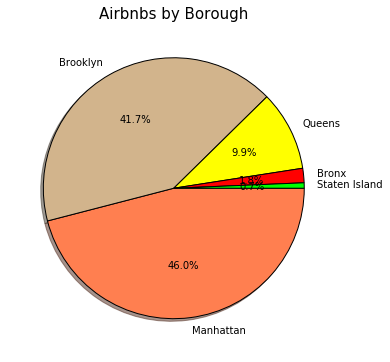

In [330]:
labels = ls.neighbourhood_group.value_counts().index
colors = ['coral','tan','yellow','red','lime']

explode = [0,0,0,0,0]
sizes = ls.neighbourhood_group.value_counts().values

plt.figure(0,figsize = (6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, 
                 counterclock=False, wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True})
plt.title('Airbnbs by Borough',color = 'k',fontsize = 15)
plt.show()

### <b> Question 2: </b>
Is there a difference in the price, popularity, and ratings for different areas? Do additional research to learn why.

#### Price

In [44]:
rp.summary_cont(ls['price'])

Variable        N        Mean          SD        SE   95% Conf.    Interval
0    price  38782.0  158.630035  152.922626  0.776527  157.108022  160.152047

That gives us data by whole, but we really are interested in the data by borough

In [45]:
ls.price.groupby(ls['neighbourhood_group']).describe()

count        mean         std   min   25%    50%  \
neighbourhood_group                                                       
Bronx                  504.0  106.007937   96.730467  51.0  65.0   80.0   
Brooklyn             15386.0  133.548941  132.683745  51.0  75.0  100.0   
Manhattan            19320.0  188.033592  171.014278  51.0  99.0  150.0   
Queens                3350.0  113.918806   90.882380  51.0  69.0   90.0   
Staten Island          222.0  132.166667  135.448590  51.0  75.0   95.0   

                        75%     max  
neighbourhood_group                  
Bronx                105.00   862.0  
Brooklyn             150.00  8000.0  
Manhattan            215.00  3000.0  
Queens               125.00  1800.0  
Staten Island        143.75  1500.0

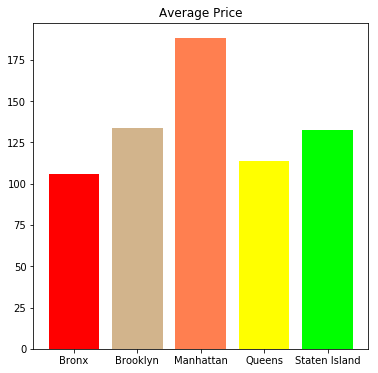

In [134]:
# Price

colors=['red','tan','coral','yellow','lime']
price_group = ls[["neighbourhood_group","price"]].groupby(["neighbourhood_group"]).price.mean()
plt.figure(figsize = (6,6))
plt.bar(range(len(price_group.values)),price_group.values, color=colors)
plt.xticks(range(len(price_group.values)),list(price_group.index))
plt.title("Average Price");

It seems like Airbnb's in Manhattan are the most expensive overall in comparison to the other neighborhood groups, which makes sense since that is the busiest borough and where tourists or business people would ideally stay. Staten Island and Brooklyn are the next most expensive and have almost equal means (132 and 133). Then Queens and finally the Bronx is the least expensive on average, however, it is pretty close to the other three group overall. The Bronx has the lowest median rent and median income so this makes sense. 

Median gross rent from high to low from 2013-2017: Manhattan (\\$1,615), Queens (\\$1,456), Brookyln (\\$1,314), Staten Island (\\$1,229), and then Bronx (\\$1,133)

Median household income (from 2013-2017) from high to low: Manhattan (\\$79,781), Staten Island (\\$76,244), Queens (\\$62,008), Brooklyn (\\$52,781), Bronx (\\$36,593)

Top prices overall:

In [123]:
a=ls[['price','neighbourhood','neighbourhood_group']].sort_values(by=['price'],ascending=False)[:5]
a

price      neighbourhood neighbourhood_group
id                                                    
2953058    8000       Clinton Hill            Brooklyn
2952861    4500       Clinton Hill            Brooklyn
14730708   3000    Upper West Side           Manhattan
18071399   3000            Chelsea           Manhattan
13882394   2800  Greenwich Village           Manhattan

Top prices by neighborhood and borough:

In [151]:
a=ls[['price','neighbourhood','neighbourhood_group']]
a=a.sort_values(['neighbourhood_group','price'],ascending=False).groupby('neighbourhood_group').head(3)
a

price       neighbourhood neighbourhood_group
id                                                     
2176866    1500         Westerleigh       Staten Island
20828667    800         Tottenville       Staten Island
1798271     700             Woodrow       Staten Island
20647533   1800            Flushing              Queens
12156541   1100           Briarwood              Queens
18175061   1000           Briarwood              Queens
18071399   3000             Chelsea           Manhattan
14730708   3000     Upper West Side           Manhattan
13882394   2800   Greenwich Village           Manhattan
2953058    8000        Clinton Hill            Brooklyn
2952861    4500        Clinton Hill            Brooklyn
4823682    2000  Bedford-Stuyvesant            Brooklyn
16057443    862          West Farms               Bronx
15556066    850           Fieldston               Bronx
16033923    838            Van Nest               Bronx

It may be better to look at top average prices instead.

In [169]:
a=ls[['price','neighbourhood','neighbourhood_group']].groupby(['neighbourhood','neighbourhood_group'],as_index=False).agg({'price':'mean'}).sort_values(['neighbourhood_group','price'],ascending=False)
a=a.groupby(['neighbourhood_group']).head(3)
a

neighbourhood neighbourhood_group       price
207        Westerleigh       Staten Island  801.500000
214            Woodrow       Staten Island  472.500000
189          Todt Hill       Staten Island  316.000000
96        Hollis Hills              Queens  267.500000
105    Jamaica Estates              Queens  239.857143
97          Holliswood              Queens  220.500000
193            Tribeca           Manhattan  359.664516
142               NoHo           Manhattan  347.975000
72   Flatiron District           Manhattan  316.892473
128         Mill Basin            Brooklyn  500.000000
170           Sea Gate            Brooklyn  313.750000
50               DUMBO            Brooklyn  219.666667
199           Van Nest               Bronx  450.666667
188        Throgs Neck               Bronx  257.875000
204         West Farms               Bronx  236.200000

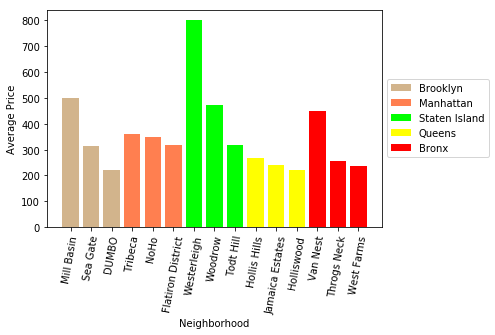

In [170]:
a1=a[a['neighbourhood_group']=='Manhattan']
a2=a[a['neighbourhood_group']=='Brooklyn']
a3=a[a['neighbourhood_group']=='Staten Island']
a4=a[a['neighbourhood_group']=='Queens']
a5=a[a['neighbourhood_group']=='Bronx']

plt.bar(a2.neighbourhood,a2['price'],color='tan',label='Brooklyn')
plt.bar(a1.neighbourhood,a1['price'],color='coral',label='Manhattan')
plt.bar(a3.neighbourhood,a3['price'],color='lime',label='Staten Island')
plt.bar(a4.neighbourhood,a4['price'],color='yellow',label='Queens')
plt.bar(a5.neighbourhood,a5['price'],color='red',label='Bronx')


plt.xticks(rotation=80)
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Lowest prices overall:

In [171]:
a=ls[['price','neighbourhood','neighbourhood_group']].sort_values(by=['price'])[:5]
a

price       neighbourhood neighbourhood_group
id                                                     
18737220     51          Kensington            Brooklyn
17560543     51              Harlem           Manhattan
13312655     51        Williamsburg            Brooklyn
6645516      51  Washington Heights           Manhattan
8992714      51  Bedford-Stuyvesant            Brooklyn

Lowest prices by neighborhood and borough:

In [172]:
a=ls[['price','neighbourhood','neighbourhood_group']]
a=a.sort_values(['neighbourhood_group','price']).groupby('neighbourhood_group').head(3)
a

price       neighbourhood neighbourhood_group
id                                                     
18898125     51             Fordham               Bronx
1278784      52          Mott Haven               Bronx
4937093      52        Clason Point               Bronx
14670685     51  Bedford-Stuyvesant            Brooklyn
18926057     51  Bedford-Stuyvesant            Brooklyn
20425419     51  Bedford-Stuyvesant            Brooklyn
857696       51         East Harlem           Manhattan
15531089     51        East Village           Manhattan
18848869     51              Harlem           Manhattan
21022242     51             Astoria              Queens
19877847     51             Astoria              Queens
20648350     51            Elmhurst              Queens
16232783     51         Great Kills       Staten Island
19878366     51          St. George       Staten Island
15036294     52         Grymes Hill       Staten Island

Since there's no variation among the lowest prices, it may be better to look at the neighborhoods with the lowest prices on average instead.

In [173]:
a=ls[['price','neighbourhood','neighbourhood_group']].groupby(['neighbourhood','neighbourhood_group'],as_index=False).agg({'price':'mean'}).sort_values(['neighbourhood_group','price'])
a=a.groupby(['neighbourhood_group']).head(3)
a

neighbourhood neighbourhood_group       price
206  Westchester Square               Bronx   60.000000
134          Mount Eden               Bronx   63.500000
131         Morris Park               Bronx   65.000000
49        Cypress Hills            Brooklyn   87.472727
127             Midwood            Brooklyn   96.816901
78        Fort Hamilton            Brooklyn   97.540541
120         Marble Hill           Manhattan   97.600000
102              Inwood           Manhattan   98.827411
202  Washington Heights           Manhattan  106.308495
81            Glen Oaks              Queens   71.666667
47               Corona              Queens   76.937500
11            Bayswater              Queens   82.000000
140      New Dorp Beach       Staten Island   62.000000
141     New Springville       Staten Island   66.250000
88          Great Kills       Staten Island   76.200000

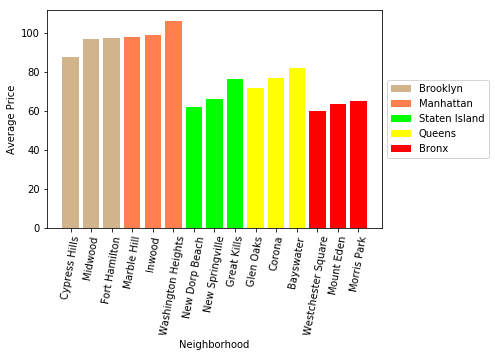

In [174]:
a1=a[a['neighbourhood_group']=='Manhattan']
a2=a[a['neighbourhood_group']=='Brooklyn']
a3=a[a['neighbourhood_group']=='Staten Island']
a4=a[a['neighbourhood_group']=='Queens']
a5=a[a['neighbourhood_group']=='Bronx']

plt.bar(a2.neighbourhood,a2['price'],color='tan',label='Brooklyn')
plt.bar(a1.neighbourhood,a1['price'],color='coral',label='Manhattan')
plt.bar(a3.neighbourhood,a3['price'],color='lime',label='Staten Island')
plt.bar(a4.neighbourhood,a4['price'],color='yellow',label='Queens')
plt.bar(a5.neighbourhood,a5['price'],color='red',label='Bronx')


plt.xticks(rotation=80)
plt.xlabel('Neighborhood')
plt.ylabel('Average Price')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

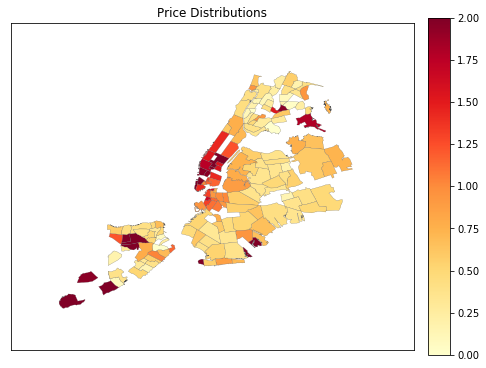

In [175]:
# Price Geometry Distribution 

prices = listings_detail[["neighbourhood","price","reviews_per_month"]].groupby(["neighbourhood"]).price.mean()
priceMap = dict(prices)

max_ = max(priceMap.values())
min_ = min(priceMap.values())
def norm_transform(price):
    return (price-min_)/( 250 - min_)#Hard Coding Truncature Here at 250 USD here to see a more meaningful result

#Set up limits
mp = nbgeo.geometry.loc[101]
cm = plt.get_cmap('YlOrRd')


fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
minx, miny, maxx, maxy = mp.bounds
w, h = maxx - minx, maxy - miny
ax.set_xlim(minx - 20 * w, maxx + 5 * w)
ax.set_ylim(miny - 10 * h, maxy + 8 * h)
ax.set_aspect(1)

#Add neighborhoods
for i in range(len(nbgeo.geometry)):
    patches = []
    mp = nbgeo.geometry.loc[i]
    nb = nbgeo.neighbourhood.loc[i]
    try:
        price = priceMap[nb]
    except:
        continue
    for idx, p in enumerate(mp):
        colour = cm(norm_transform(price))
        patches.append(PolygonPatch(p, fc=colour, ec='#555555', lw=0.2, alpha=1., zorder=1))
        ax.add_collection(PatchCollection(patches, match_original=True))

#Plot
ax.set_xticks([])
ax.set_yticks([])
plt.title("Price Distributions")
plt.tight_layout()
#NOTE that the price values are normalized 
ax  = fig.add_axes([1,0.11,0.05,0.78])
norm = mpl.colors.Normalize(vmin=0,vmax=2)
cb1  = mpl.colorbar.ColorbarBase(ax,cmap=cm,norm=norm,orientation='vertical')

plt.show()

#### Popularity
We are defining popularity in terms of availibilty, meaning more popular airbnb's have less availability and less popular ones have more

In [183]:
#Merge listing details and listing summary to get neighborhood group in listing details
ldmergels=pd.merge(listings_detail,ls,left_index=True, right_index=True, how='left')

In [188]:
listings_detail.availability_365.groupby(ldmergels['neighbourhood_group']).sum()
#Number of availibilities by neighborhood - higher means less popular

neighbourhood_group
Bronx             105277.0
Brooklyn         1942619.0
Manhattan        2252377.0
Queens            574538.0
Staten Island      48547.0
Name: availability_365, dtype: float64

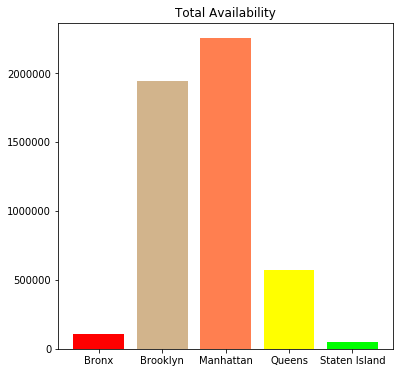

In [190]:
# Total Availability
colors=['red','tan','coral','yellow','lime']

avail_group =listings_detail.availability_365.groupby(ldmergels["neighbourhood_group"]).sum()
plt.figure(figsize = (6,6))
plt.bar(range(len(avail_group.values)),avail_group.values, color=colors)
plt.xticks(range(len(avail_group.values)),list(avail_group.index))
plt.title("Total Availability");

This can be misleading since there are way more Airbnbs in general in Manhattan and Brooklyn, so there will therefore be more available rooms. Maybe we can make this relative to the amount of Airbnb's there are so that we get an average available days per Airbnb by neighborhood.

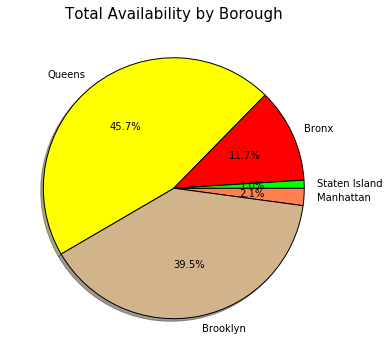

In [192]:
labels = ls.neighbourhood_group.value_counts().index
colors = ['coral','tan','yellow','red','lime']

explode = [0,0,0,0,0]
sizes = listings_detail.availability_365.groupby(ldmergels["neighbourhood_group"]).sum()#ls.neighbourhood_group.value_counts().values

plt.figure(0,figsize = (6,6))

plt.title('Total Availability by Borough',color = 'k',fontsize = 15)
_, _, autotexts = plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, 
                 counterclock=False, wedgeprops={"edgecolor":"k",'linewidth': 1,'antialiased': True})
plt.show()

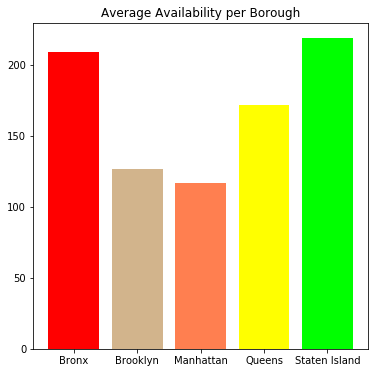

In [195]:
# Average Availability
colors=['red','tan','coral','yellow','lime']

avail_group = (listings_detail["availability_365"].groupby(ldmergels["neighbourhood_group"]).sum())/(listings_detail['host_id'].groupby(ldmergels['neighbourhood_group']).count())
plt.figure(figsize = (6,6))
plt.bar(range(len(avail_group.values)),avail_group.values, color=colors)
plt.xticks(range(len(avail_group.values)),list(avail_group.index))
plt.title("Average Availability per Borough");

This is the availability relative to the amount of Airbnb's in the area. This plot paints a much different picture which is much more accurate. For the amount of Airbnb's there are in Staten Island, they are on average more available than any other neighbourhood group (least popular). The Bronx also has a lot of availability on average compared to the others - so we could say the Bronx is the second to least popular. Queens seems to be the more popular than Staten Island and the Bronx since it has less availability than those. Brooklyn, and Manhattan have VERY similar averages which is interesting - so they have about the same popularity and are the msot popular. 

I used the values below to check that the average was calculated properly which it was. It is the amount of available days per neighbourhood group divided by the total number of Airbnbs in each neighborhood group - to get the average amount of available days per Airbnb within each neighborhood group (borough)

In [109]:
#Check the averages:
avail_group/(ldmergels['host_id'].groupby(ldmergels['neighbourhood_group']).count())

neighbourhood_group
Bronx            205.924147
Brooklyn         121.737845
Manhattan        115.650368
Queens           170.364982
Staten Island    222.336735
dtype: float64

In [108]:
avail_group #Used this to check that this is the amount of available days for each neighborhood group 

neighbourhood_group
Bronx            162886 
Brooklyn         2248498
Manhattan        2355798
Queens           748243 
Staten Island    65367  
Name: availability_365, dtype: int64

##### Are there times when no Airbnbs are available or extremely limited and on what dates does this occur?

In [31]:
cdmergels.available.groupby(cdmergels.date).sum().sort_values()[:10]

date
2017-10-02    190
2017-10-07    309
2017-10-06    331
2017-10-03    397
2017-10-05    401
2017-10-04    435
2017-10-08    467
2017-10-13    559
2017-10-14    569
2017-10-09    593
Name: available, dtype: int64

There are no times when there are no Airbnbs available but the dates when the fewest are available are October 10, October 7, October 6, October 3, and October 5, 2017 

In [32]:
cdmergels.available.groupby(cdmergels.date).sum().sort_values(ascending=False)[:10]

date
2018-03-20    1849
2018-03-22    1846
2018-03-21    1845
2018-03-19    1843
2018-03-23    1843
2018-03-17    1839
2018-03-18    1838
2018-03-25    1834
2018-03-24    1832
2018-03-15    1831
Name: available, dtype: int64

The dates with the greatest number of Airbnb's available are around March 20th, 2018

##### On what dates do the most crime occur?

In [124]:
crime.OFNS_DESC.groupby(crime['ARREST_DATE']).count().sort_values()[:5]

ARREST_DATE
2014-09-06    54 
2014-12-25    136
2017-12-25    161
2015-12-25    185
2014-12-31    212
Name: OFNS_DESC, dtype: int64

In [125]:
crime.OFNS_DESC.groupby(crime['ARREST_DATE']).count().sort_values(ascending=False)[:5]

ARREST_DATE
2014-10-08    1420
2014-10-09    1410
2014-10-14    1378
2015-02-12    1374
2014-10-17    1369
Name: OFNS_DESC, dtype: int64

The most amount of crimes occurred on October 8th,9th and 14th, 2014, February 12th, 2015, and October 17, 2014. The least amount of crimes occurred on September 6, 2014, December 31, 2014, and December 25 for the years 2014 ,2015 and 2017. It is very interesting and kind of sweet that the lowest amounts of crime occur on Christmas for multiple years in a row. We also thought it was interesting that New Years Eve in 2014 had such a low amount of crime since we would have expected the opposite. 

#### Reviews

In [21]:
#Need to see whole record to read the full review
pd.set_option('display.max_colwidth', -1)

In [133]:
len(reviews.index)

801784

There are 801,784 reviews total. First we will try to extract as many positive comments as possible. However, we may not account for all of them since there are so many different positive words that can be included in the comments. Also, some comments have some positive feedback and some negative feeback as well. In these cases, the goal is that the comment is counted as both positive and negative. We define positive comments as those that include at least one of the positive words in the regular expression below and then negative comments are ones that containe at least one of the negative words. Some comments were counted as both positive and negative if they had both positive and negative words included in the comment.

In [74]:
reviews['goodcomments'] = reviews['comments'].str.contains('good|great|wonderful|love|nice|loved|prompt|awesome|easy|lovely|accommodating|neat|perfect|would_recommend|terrific|fantastic|responsive|kind|pleasure|pleasant|ideal|convenient|beautiful|clean|enjoy|easily_accessible|friendly|welcoming|quiet|helpful|comf|best|reasonable|priva|communicative|appreciate|modern|value|thank|decent|cool|worth|amazing', case=False)

In [75]:
len(reviews[reviews['goodcomments']==True])

696965

696,965 reviews are considered "positive" by our definition, meaning they contain at least one of the words above. This is not a perfect approach and it is not guarenteed that all of these comments are positive but that is what we are assuming. Next, we try to find reviews that are considered negative, meaning they contain at least one of the negative words in the regular expression below.It's also important to note  that there are many cases where the review is in a different language or a default review of "The host canceled this reservation. This is an automated posting." We don't want those to be considered negative since they may not be. In these cases, we don't want these comments to be considered positive or negative. I'm not sure how we could delete those comments. 

In [77]:
reviews['badcomments']=reviews['comments'].str.contains('messy|dirty|expensive|loud|nois|bugs|warning|bad|awful|refund|disappoint|terrible|shame|unhappy|unhelpful|annoy|disgusting|"not recommend"',case=False)

In [78]:
len(reviews[reviews['badcomments']==True])

53358

In [50]:
len(reviews[reviews['goodcomments']==True])+len(reviews[reviews['badcomments']==True])

750323

So we've only accounted for 750323 out of the 801784 reviews total. We may still need to try to find out the number of reviews that are automated or in a different language to see how many we have missed. 

In [79]:
reviewsmergels=pd.merge(reviews, ls, left_index=True, right_index=True, how='left')

In [80]:
reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()

neighbourhood_group
Bronx            11747 
Brooklyn         282276
Manhattan        321962
Queens           75699 
Staten Island    5281  
Name: goodcomments, dtype: int64

In [29]:
reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()

neighbourhood_group
Bronx            753  
Brooklyn         19243
Manhattan        28237
Queens           4768 
Staten Island    357  
Name: badcomments, dtype: int64

Since there is such a small amount of negative reviews compared to positive, using the information above would create a terrible graph (you can't even see the bar for negative reviews since it is so small). In the next graph we plot the two separately, so we can see the distributions of the negative reviews as well as the positive reviews for each borough. It is important to note that the range of the y-axis scales are very different.

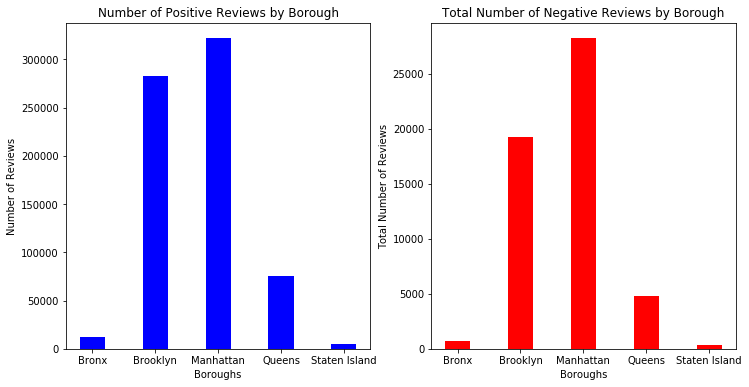

In [143]:
fig, ax = plt.subplots(figsize=(12,6))
x=range(len(y))
x1=[0.4,1.4,2.4,3.4,4.4]
y=reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()
z=reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()
ax=plt.subplot(121)
ax.bar(x,y,color='b',width=0.4,align='center')
plt.xlabel('Boroughs')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Number of Positive Reviews by Borough')

ax=plt.subplot(122)
ax.bar(x,z,color='r',width=0.4,align='center')
plt.xlabel('Boroughs')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Total Number of Reviews')
plt.title('Total Number of Negative Reviews by Borough')


plt.show()

We should probably find the average number of positive/negative reviews per borough like we did before with the availability. Since obviously Manhattan and Brooklyn are likely to have the most reviews since they have the most Airbnbs. 

In [97]:
reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()/(ls['host_id'].groupby(ls['neighbourhood_group']).count())

neighbourhood_group
Bronx            14.850822
Brooklyn         15.282945
Manhattan        15.805695
Queens           17.235656
Staten Island    17.962585
dtype: float64

In [38]:
reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()/(ls['host_id'].groupby(ls['neighbourhood_group']).count())

neighbourhood_group
Bronx            0.951960
Brooklyn         1.041852
Manhattan        1.386205
Queens           1.085610
Staten Island    1.214286
dtype: float64

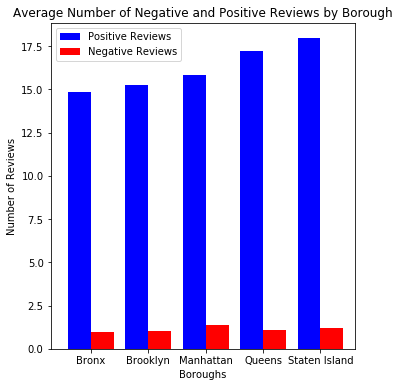

In [81]:
fig, ax = plt.subplots(figsize=(12,6))

x=[.2,1.2,2.2,3.2,4.2]
x1=[0.6,1.6,2.6,3.6,4.6]
y=reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()/(ls['host_id'].groupby(ls['neighbourhood_group']).count())
z=reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()/(ls['host_id'].groupby(ls['neighbourhood_group']).count())

ax=plt.subplot(121)
ax.bar(x,y,color='b',width=0.4,align='center',label='Positive Reviews')
ax.bar(x1,z,color='r',width=0.4,align='center',label='Negative Reviews')
plt.xlabel('Boroughs')
plt.xticks((0.4,1.4,2.4,3.4,4.4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Average Number of Negative and Positive Reviews by Borough')
plt.xlim(-.3,5)
##Need to add legend if we want to use this graph
leg=ax.legend()
plt.show()

Or if we want to plot the two separately to get a better sense of the distribution of negative comments:

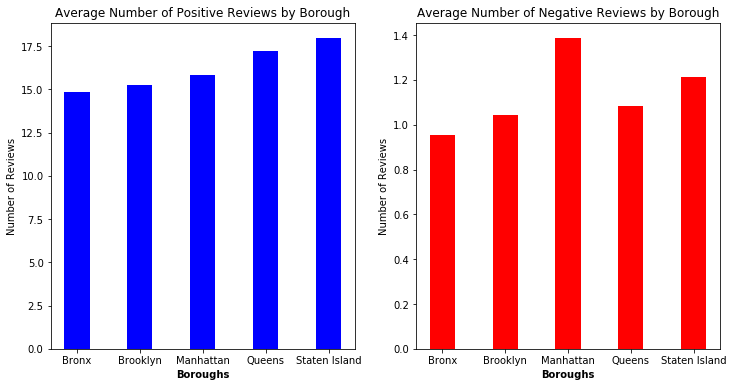

In [82]:
fig, ax = plt.subplots(figsize=(12,6))

y=reviewsmergels['goodcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()/(ls['host_id'].groupby(ls['neighbourhood_group']).count())
z=reviewsmergels['badcomments'].groupby(reviewsmergels['neighbourhood_group']).sum()/(ls['host_id'].groupby(ls['neighbourhood_group']).count())
x=range(len(y))

ax=plt.subplot(121)
ax.bar(x,y,color='b',width=0.4,align='center')
plt.xlabel('Boroughs',weight='bold')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Average Number of Positive Reviews by Borough')

ax=plt.subplot(122)
ax.bar(x,z,color='r',width=0.4,align='center')
plt.xlabel('Boroughs',weight='bold')
plt.xticks((0,1,2,3,4),['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.ylabel('Number of Reviews')
plt.title('Average Number of Negative Reviews by Borough')


plt.show()

In [78]:
#Don't want to see whole record anymore since some have paragraph entries
pd.reset_option("^display")

Now we will look at the average review score rating by borough.

In [ ]:
ldmergels.review_scores_rating.groupby(ldmergels['neighbourhood_group']).mean()

### Visualize Airbnb Data on Map
- What areas are most popular? why?

In [74]:
import folium
from random import sample 
from folium.plugins import HeatMap
# positions = [] 
# for index, row in arrest.iterrows():
positions = list(zip(ls['latitude'], ls['longitude']))
tiles = 'Stamen Terrain'
fol = folium.Map(location=[40.75,-73.98], zoom_start=10, tiles = tiles)
pos_samp = sample(positions, 22000)#22K is the max now as we join both DS togather 
HeatMap(pos_samp, radius = 8).add_to(fol) 
fol.save('map.html')
fol

We have already gone over the areas with the most Airbnbs but this is a nice visualization to actually see it on a map. The densest areasa are lower Manhattan and the Eastern part of Brooklyn. This makes sense since this is closest to the "heart of the city" and would be ideal for tourists or business people who do not have cars and don't want to take multiple transits to get to where they want. From there, the amount of Airbnbs continutes to decrease the further you go from Manhattan. Only about half of Staten Island even has Airbnbs, which makes sense since it is mostly residential. 

### Distribution of Crime in NYC

In [322]:
crime.isna().sum()

ARREST_DATE          0   
PD_CD                0   
PD_DESC              2963
KY_CD                2963
OFNS_DESC            2963
LAW_CODE             0   
LAW_CAT_CD           4736
ARREST_BORO          0   
ARREST_PRECINCT      0   
JURISDICTION_CODE    0   
AGE_GROUP            0   
PERP_SEX             0   
PERP_RACE            0   
X_COORD_CD           0   
Y_COORD_CD           0   
Latitude             0   
Longitude            0   
dtype: int64

In [326]:
2963/len(crime)

0.00282573969434709

Since this is 2.8% of our data, we decided to keep it especially since these records with some missing values also include other information of interest to us. 

In [4]:
crime['ARREST_DATE'].groupby(crime['ARREST_BORO']).count()

ARREST_BORO
B    231816
K    290122
M    284736
Q    203482
S     38419
Name: ARREST_DATE, dtype: int64

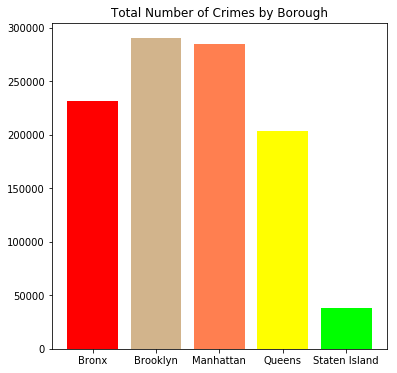

In [216]:
colors=['red','tan','coral','yellow','lime']
x=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
plt.figure(figsize = (6,6))
plt.bar(range(len(x)),crime['ARREST_DATE'].groupby(crime['ARREST_BORO']).count(), color=colors)
plt.xticks(range(len(x)),x)

plt.title("Total Number of Crimes by Borough");

<b> Should we look at averages and how?


I tried to merge crime and airbnb data in order to match up the Longitude and Latitude to get the neighborhoods into the crime data. However, since the coordinates are not exact, there were no matches. Instead we will look at crimes by precinct and then see what neighborhoods are in those precincts.

By Precinct:

In [42]:
crime.ARREST_DATE.groupby(crime['ARREST_PRECINCT']).count().sort_values()[:5]

ARREST_PRECINCT
22     926 
111    4842
94     5037
123    5053
17     5232
Name: ARREST_DATE, dtype: int64

In [43]:
crime.ARREST_DATE.groupby(crime['ARREST_PRECINCT']).count().sort_values(ascending=False)[:5]

ARREST_PRECINCT
14    37941
40    34596
75    33878
44    29715
73    25791
Name: ARREST_DATE, dtype: int64

These are the precincts with the lowest and highest amounts of crime. 

<b>Low:</b>

The 22nd precinct is the Central Park precinct and makes sense that it's crime rate is so low compared to other precincts since this is mostly a tourist spot and is relatively safe. Also, many people do not go to Central Park at night, since it is not well lit, which is when majority of the crime would occur. Some people say it's "one of the safest places in the city" (Celona). The 111th Precinct is in the northeast portion of Queens anc contains the following neighborhoods: Bayside, Douglaston, Little Neck, Auburndale, Hollis Hills, and Fresh Meadows. The 94th precinct serves the northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint. The 123rd Precinct serves a portion of the South Shore of Staten Island, including Tottenville, Huguenot, Rossville, Annadale, and Eltingville. This is the farthest portion of Staten Island from the city and makes sense that it is one of the precincts with the lowest amount of crime.The 17th Precinct serves the east side of Midtown, Manhattan. Some of the neighborhoods it covers are Sutton Area, Beekman Place, Kipps Bay, Turtle Bay, Murray Hill, and the Rose Hill Community.

<b>High:</b>

The 14th precinct is called the Midtown South Precinct and serves the southern portion of Midtown, Manhattan. The area contains commercial offices, hotels, Times Square, Grand Central Terminal, Penn Station, Madison Square Garden, Koreatown section, and the Manhattan Mall Plaza. The 40th Precinct is the southernmost precinct in the borough of the Bronx. Nearby, the 44th Precinct serves 1.97 square miles of the southwest portion of the Bronx: The precinct is home to the Grand Concourse, Bronx Terminal Market, and Yankee Stadium. The precinct serves Port Morris, Mott Haven, and Melrose. The 75th Precinct serves the easternmost portion of Brooklyn and envelopes East New York and Cypress Hills. The 73rd Precinct serves a northeastern area of Brooklyn containing Brownsville and Ocean Hill (NYC.gov).

Now we will look at the different types of crimes that occur in these precincts to hopefully get a better understanding of why these areas have some of the highest and lowest amounts of crime. 

Types of crime in the precincts with the lowest crime rates:

In [247]:
low=crime[crime['ARREST_PRECINCT'].isin([22,111,94,123,17])]
x=low[['ARREST_DATE','ARREST_PRECINCT','PD_DESC']].groupby(['ARREST_PRECINCT','PD_DESC'],as_index=False).agg({'ARREST_DATE':'count'}).sort_values(by=['ARREST_PRECINCT','ARREST_DATE','PD_DESC'],ascending=False)
x=x.groupby(['ARREST_PRECINCT']).head(3)
x=x.rename(columns={'ARREST_DATE': "COUNT"})
x

ARREST_PRECINCT                                     PD_DESC  COUNT
500  123              CONTROLLED SUBSTANCE, POSSESSION 7          683  
536  123              LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  509  
592  123              TRAFFIC,UNCLASSIFIED MISDEMEAN              433  
395  111              INTOXICATED DRIVING,ALCOHOL                 591  
466  111              TRAFFIC,UNCLASSIFIED MISDEMEAN              531  
348  111              ASSAULT 3                                   392  
319  94               THEFT OF SERVICES, UNCLASSIFIED             569  
206  94               ASSAULT 3                                   467  
262  94               LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  443  
192  22               TRAFFIC,UNCLASSIFIED MISDEMEAN              178  
170  22               NY STATE LAWS,UNCLASSIFIED MISDEMEANOR      144  
135  22               CONTROLLED SUBSTANCE, POSSESSION 7          82   
112  17               TRAFFIC,UNCLASSIFIED MISDEMEAN              597  
55   17               LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  540  
107  17               THEFT OF SERVICES, UNCLASSIFIED             428

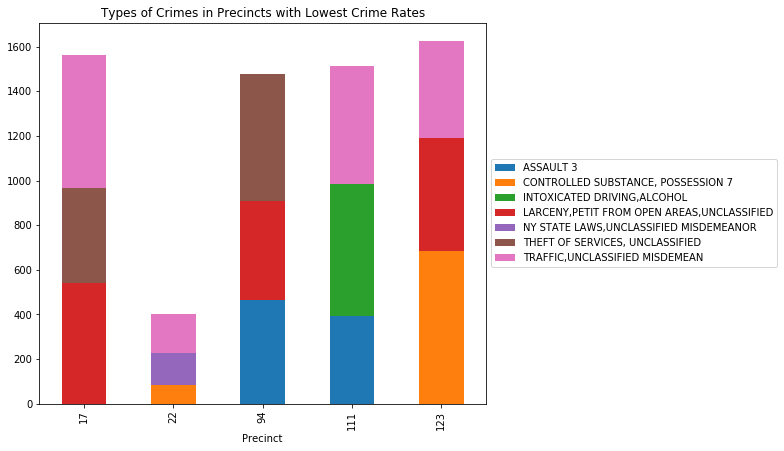

In [248]:
pivot_df = x.pivot(index='ARREST_PRECINCT', columns='PD_DESC', values='COUNT')
ax=pivot_df.plot.bar(stacked=True, figsize=(10,7))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Precinct')
plt.title('Types of Crimes in Precincts with Lowest Crime Rates')
plt.show()

Types of crime in the precincts with the highest crime rates:

In [166]:
high=crime[crime['ARREST_PRECINCT'].isin([14,40,75,44, 73])]

In [244]:
y=high[['ARREST_DATE','ARREST_PRECINCT','PD_DESC']].groupby(['ARREST_PRECINCT','PD_DESC'],as_index=False).agg({'ARREST_DATE':'count'}).sort_values(by=['ARREST_PRECINCT','ARREST_DATE','PD_DESC'],ascending=False)
y=y.groupby(['ARREST_PRECINCT']).head(3)
y=y.rename(columns={'ARREST_DATE': "COUNT"})
y

ARREST_PRECINCT                                     PD_DESC  COUNT
774  75               ASSAULT 3                                   2967 
951  75               THEFT OF SERVICES, UNCLASSIFIED             2712 
860  75               LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  1948 
737  73               THEFT OF SERVICES, UNCLASSIFIED             2286 
578  73               ASSAULT 3                                   2022 
678  73               NY STATE LAWS,UNCLASSIFIED VIOLATION        1595 
544  44               THEFT OF SERVICES, UNCLASSIFIED             3321 
378  44               ASSAULT 3                                   2489 
460  44               LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  2301 
347  40               THEFT OF SERVICES, UNCLASSIFIED             4832 
192  40               ASSAULT 3                                   3066 
280  40               MARIJUANA, POSSESSION 4 & 5                 2424 
160  14               THEFT OF SERVICES, UNCLASSIFIED             8893 
91   14               LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  7951 
118  14               NY STATE LAWS,UNCLASSIFIED VIOLATION        3038

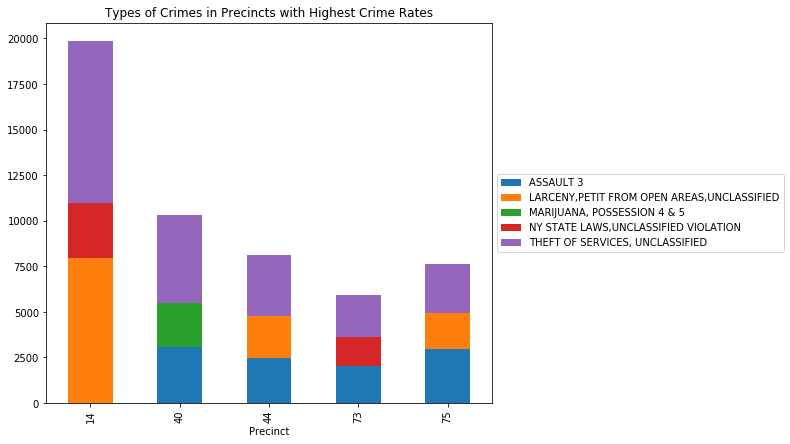

In [245]:
pivot_df = y.pivot(index='ARREST_PRECINCT', columns='PD_DESC', values='COUNT')
ax=pivot_df.plot.bar(stacked=True, figsize=(10,7))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Precinct')
plt.title('Types of Crimes in Precincts with Highest Crime Rates')
plt.show()

Most common types of crime by borough:

In [240]:
z=crime[['ARREST_DATE','ARREST_BORO','PD_DESC']].groupby(['ARREST_BORO','PD_DESC'],as_index=False).agg({'ARREST_DATE':'count'}).sort_values(by=['ARREST_BORO','ARREST_DATE','PD_DESC'],ascending=False)
z=z.groupby(['ARREST_BORO']).head(3)
z=z.rename(columns={'ARREST_DATE': "COUNT"})
z

ARREST_BORO                                     PD_DESC  COUNT
1229  S           LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  3753 
1166  S           CONTROLLED SUBSTANCE, POSSESSION 7          3511 
1144  S           ASSAULT 3                                   3271 
861   Q           ASSAULT 3                                   19964
975   Q           LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  14027
1107  Q           TRAFFIC,UNCLASSIFIED MISDEMEAN              11571
813   M           THEFT OF SERVICES, UNCLASSIFIED             33269
696   M           LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  30624
575   M           ASSAULT 3                                   18044
286   K           ASSAULT 3                                   24604
529   K           THEFT OF SERVICES, UNCLASSIFIED             23424
406   K           LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED  18045
15    B           ASSAULT 3                                   23811
244   B           THEFT OF SERVICES, UNCLASSIFIED             18310
147   B           MARIJUANA, POSSESSION 4 & 5                 16137

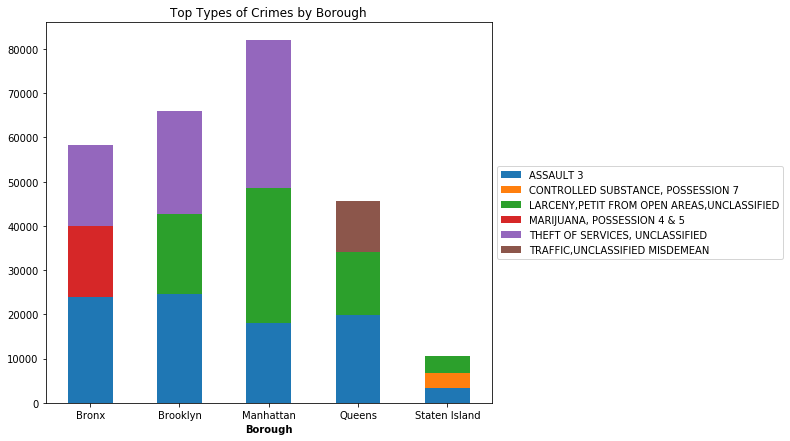

In [242]:
pivot_df = z.pivot(index='ARREST_BORO', columns='PD_DESC', values='COUNT')
ax=pivot_df.plot.bar(stacked=True, figsize=(10,7))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Borough',weight='bold')
ax.set_xticklabels(['Bronx','Brooklyn','Manhattan','Queens','Staten Island'])
plt.xticks(rotation=0)
plt.title('Top Types of Crimes by Borough')
plt.show()

By age:

In [195]:
age=crime.ARREST_DATE.groupby(crime['AGE_GROUP']).count().sort_values(ascending=False)
age

AGE_GROUP
25-44    505313
18-24    266034
45-64    201135
<18      66044 
65+      10049 
Name: ARREST_DATE, dtype: int64

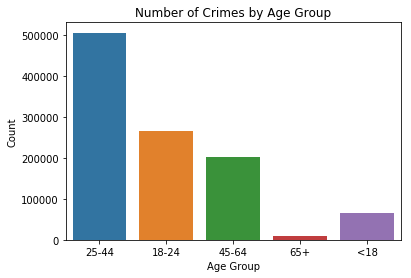

In [251]:
ax=sns.countplot(crime.AGE_GROUP)
ax.set(xlabel='Age Group', ylabel='Count',title='Number of Crimes by Age Group');

It looks like almost half of the total crimes are committed by people between the ages of 25 to 44. Then ages 18-24 are the next largest portion followed by 46-64. People over 65 have a very low amount of crimes in comparison to the other age groups, which is expected. Under 18 is the second to smallest portion of total crimes but it is still a large number (66,044) which is still a lot of crimes and is sad that kids that young are in situations where they are already committing crimes. 

By race:

In [163]:
crime.ARREST_DATE.groupby(crime['PERP_RACE']).count().sort_values(ascending=False)

PERP_RACE
BLACK                             501130
WHITE HISPANIC                    266770
WHITE                             128261
BLACK HISPANIC                    89080 
ASIAN / PACIFIC ISLANDER          50432 
UNKNOWN                           10417 
AMERICAN INDIAN/ALASKAN NATIVE    2485  
Name: ARREST_DATE, dtype: int64

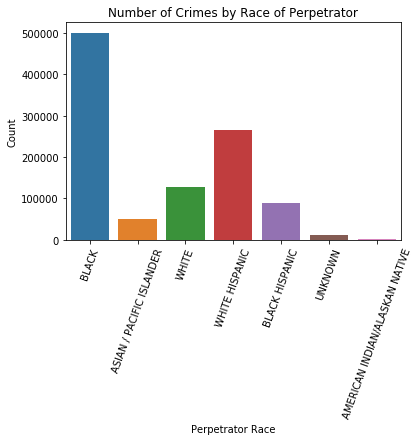

In [250]:
ax=sns.countplot(crime.PERP_RACE)
ax.set(xlabel='Perpetrator Race', ylabel='Count',title='Number of Crimes by Race of Perpetrator')
plt.xticks(rotation=70);

It seems like in this data the majority of perpetrators are black, then white hispanic is second, and white is third. This could be due to underlying racial issues that are still present, however, that is outside the scope of our project and this is simply what our data shows. 

By gender:

In [164]:
crime.ARREST_DATE.groupby(crime['PERP_SEX']).count().sort_values(ascending=False)

PERP_SEX
M    868306
F    180269
Name: ARREST_DATE, dtype: int64

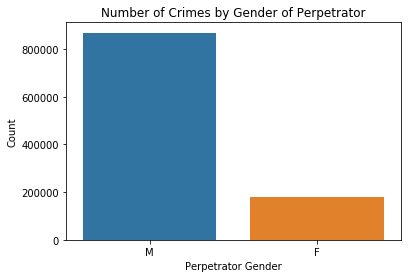

In [252]:
ax=sns.countplot(crime.PERP_SEX)
ax.set(xlabel='Perpetrator Gender', ylabel='Count',title='Number of Crimes by Gender of Perpetrator');

There is significantly more male perpetrators than female and that tends to be the steroetype but I wonder why that is. It is also possible that police may be more likely to investigate and question a male over a female but again, that is not what our project is looking into. 

Most common types of crime overall:

In [165]:
crime.ARREST_DATE.groupby(crime['PD_DESC']).count().sort_values(ascending=False)[:10]

PD_DESC
ASSAULT 3                                     89694
THEFT OF SERVICES, UNCLASSIFIED               84964
LARCENY,PETIT FROM OPEN AREAS,UNCLASSIFIED    81316
MARIJUANA, POSSESSION 4 & 5                   58562
TRAFFIC,UNCLASSIFIED MISDEMEAN                51085
CONTROLLED SUBSTANCE, POSSESSION 7            49740
ASSAULT 2,1,UNCLASSIFIED                      39698
ROBBERY,UNCLASSIFIED,OPEN AREAS               33350
NY STATE LAWS,UNCLASSIFIED VIOLATION          29306
LARCENY,GRAND FROM OPEN AREAS,UNCLASSIFIED    26147
Name: ARREST_DATE, dtype: int64

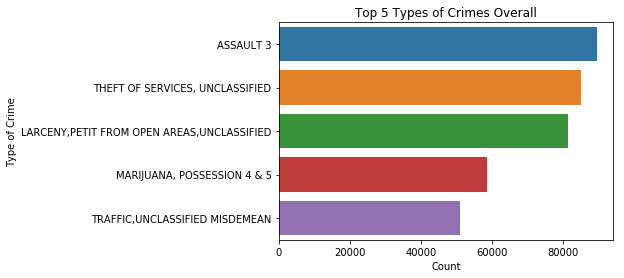

In [258]:
ax=sns.countplot(y="PD_DESC", data=crime, 
              order=crime.PD_DESC.value_counts().iloc[:5].index)
ax.set(xlabel='Count', ylabel='Type of Crime',title='Top 5 Types of Crimes Overall');

And below we can see what portion of these crimes are in each borough. This is essentially the same plot as one a few cells above but gives better representation of the amount of the types of crime per borough.

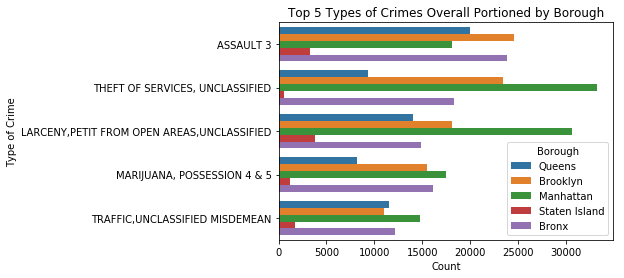

In [269]:
ax=sns.countplot(y="PD_DESC", hue="ARREST_BORO", data=crime, 
              order=crime.PD_DESC.value_counts().iloc[:5].index)
ax.set(xlabel='Count', ylabel='Type of Crime',title='Top 5 Types of Crimes Overall Portioned by Borough')
ax.legend(title='Borough',labels=['Queens','Brooklyn','Manhattan','Staten Island','Bronx']);

### Visualize Crime Data on Map

In [4]:

# positions = [] 
# for index, row in arrest.iterrows():
positions = list(zip(crime['Latitude'], crime['Longitude']))
tiles = 'Stamen Terrain'
fol = folium.Map(location=[40.75,-73.98], zoom_start=10, tiles = tiles)
pos_samp = sample(positions, 22000)#22K is the max now as we join both DS togather 
HeatMap(pos_samp, radius = 8).add_to(fol) 
fol

An alternate map visualization which gives counts:

Note this is a sample of the crime data. To view all crime data on map, need to run code in the cell two below which will save the map into your jupyter folder and then you can open that. 

In [48]:
crim=crime.sample(1000)
crime_map = folium.Map(location=[40.75,-73.98],
                        zoom_start=10,prefer_canvas=True)
mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in crim.itertuples():
    mc.add_child(folium.Marker(location=[row.Latitude,  row.Longitude],
                 popup=row.PD_DESC))
 
    crime_map.add_child(mc)
crime_map

In [ ]:
crime_map = folium.Map(location=[40.75,-73.98],
                        zoom_start=10,prefer_canvas=True)
mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in crime.itertuples():
    mc.add_child(folium.Marker(location=[row.Latitude,  row.Longitude],
                 popup=row.PD_DESC))
 
    crime_map.add_child(mc)

crime_map.save('crime map with markers') 

In [ ]:
crime_map = folium.Map(location=[40.75,-73.98],
                        zoom_start=10,prefer_canvas=True)
mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in crime.itertuples():
    mc.add_child(folium.Marker(location=[row.Latitude,  row.Longitude],
                 popup=row.PD_DESC))
 
    crime_map.add_child(mc)

crime_map.save('crime map with markers') 

### Visualize Airbnb and Crime Data 

The code below will save the map generated since there are too many points to display the output in this notebook. To see a sample of the map in the notebook, run the code two cells down. The heat portion of this map is the crime data and the circle markers with numbers are the counts of airbnbs in those areas. 

In [ ]:

# positions = [] 
# for index, row in arrest.iterrows():
positions = list(zip(crime['Latitude'], crime['Longitude']))
tiles = 'Stamen Terrain'
fol = folium.Map(location=[40.75,-73.98], zoom_start=10, tiles = tiles,prefer_canvas=True)
pos_samp = sample(positions, 22000)
HeatMap(pos_samp, radius = 8).add_to(fol) 

mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in listings_detail.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude],
                 popup=row.price))
 
    fol.add_child(mc)

fol.save('maps.html')

If you zoom in enough to see individual markers, if you click on them it will tell you the price of that airbnb.

In [50]:
crim=crime.sample(1000)
ld=listings_detail.sample(1000)

# positions = [] 
# for index, row in arrest.iterrows():
positions = list(zip(crim['Latitude'], crim['Longitude']))
tiles = 'Stamen Terrain'
fol = folium.Map(location=[40.75,-73.98], zoom_start=10, tiles = tiles,prefer_canvas=True)
pos_samp = sample(positions, 1000)
HeatMap(pos_samp, radius = 8).add_to(fol) 

mc = MarkerCluster()
#creating a Marker for each point in df_sample. Each point will get a popup with their zip
for row in ld.itertuples():
    mc.add_child(folium.Marker(location=[row.latitude,  row.longitude],
                 popup=row.price))
 
    fol.add_child(mc)
fol